### IMPORTING MODULES

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error,r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

### DOWNLOADING DATASET

In [2]:
url = "https://files.grouplens.org/datasets/movielens/ml-100k/u.data"
columns = ["user_id", "movie_id", "rating", "timestamp"]

df = pd.read_csv(url, sep="\t", names=columns)

# 19 genres in u.item, plus title column
movie_columns = ["movie_id", "title"] + [f"genre_{i}" for i in range(19)]
movies = pd.read_csv("https://files.grouplens.org/datasets/movielens/ml-100k/u.item", 
                     sep="|", encoding="latin-1", 
                     usecols=[0, 1] + list(range(5, 24)), 
                     names=movie_columns)

### DATA PREPROCESSING AND TRAIN TEST SPLIT

In [3]:
genre_names = ["Action", "Adventure", "Animation", "Children's", "Comedy", "Crime", 
               "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", 
               "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western", "Unknown"]

df = df.drop(columns=["timestamp"])

df = df.merge(movies, on="movie_id")

num_users = df["user_id"].nunique()
num_movies = df["movie_id"].nunique()

train, test = train_test_split(df, test_size=0.2, random_state=42)

train_users = train["user_id"].values
train_movies = train["movie_id"].values
train_genres = train.iloc[:, 4:].values  # Genre columns from u.item
train_ratings = train["rating"].values

test_users = test["user_id"].values
test_movies = test["movie_id"].values
test_genres = test.iloc[:, 4:].values
test_ratings = test["rating"].values

### MODEL BUILDING AND OPTIMIZATION

In [27]:
def build_model(hp):
    # Hyperparameter for embedding size
    embedding_size = hp.Int('embedding_size', min_value=20, max_value=100, step=10, default=50)
    
    # User Input & Embedding
    user_input = Input(shape=(1,), name="user_input")
    user_embedding = Embedding(input_dim=num_users + 1, output_dim=embedding_size, name="user_embedding")(user_input)
    user_vec = Flatten()(user_embedding)
    
    # Movie Input & Embedding
    movie_input = Input(shape=(1,), name="movie_input")
    movie_embedding = Embedding(input_dim=num_movies + 1, output_dim=embedding_size, name="movie_embedding")(movie_input)
    movie_vec = Flatten()(movie_embedding)
    
    # Genre Input
    genre_input = Input(shape=(19,), name="genre_input")
    
    # Concatenate User, Movie Embeddings and Genre
    concat = Concatenate()([user_vec, movie_vec, genre_input])
    
    # Define a variable number of dense layers and units per layer
    x = concat
    for i in range(hp.Int('num_layers', 1, 3)):
        units = hp.Int(f'units_{i}', min_value=32, max_value=256, step=32, default=128)
        x = Dense(units, activation="relu")(x)
    
    output = Dense(1, name="output_layer")(x)

    
    model = Model(inputs=[user_input, movie_input, genre_input], outputs=output)
    
    # Tune learning rate
    lr = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="LOG", default=1e-3)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr),
                  loss="mean_squared_error",
                  metrics=["mean_absolute_error"])
    return model

### HYPERPARAMETER TUNING

In [28]:
tuner = kt.RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=10,  # Increase this for a more thorough search
    executions_per_trial=1,
    directory="my_new_tuning_run5", 
    project_name="experiment1"
)

# Define early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

# Run hyperparameter search
tuner.search([train_users, train_movies, train_genres], train_ratings,
             validation_data=([test_users, test_movies, test_genres], test_ratings),
             epochs=10,
             batch_size=32,
             callbacks=[early_stopping])

# Retrieve the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
print(best_hyperparameters.values)

Trial 10 Complete [00h 02m 11s]
val_loss: 0.8453705310821533

Best val_loss So Far: 0.8412363529205322
Total elapsed time: 00h 17m 34s
Best Hyperparameters:
{'embedding_size': 50, 'num_layers': 1, 'units_0': 192, 'learning_rate': 0.0029710284502994224, 'units_1': 128, 'units_2': 128}


C:\Users\jaide\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### TRAIN MODEL

In [29]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = best_model.fit([train_users, train_movies, train_genres], train_ratings,
                         validation_data=([test_users, test_movies, test_genres], test_ratings),
                         epochs=100,  # further training epochs
                         batch_size=32,
                         callbacks=[early_stopping])

Epoch 1/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.7000 - mean_absolute_error: 0.6561 - val_loss: 0.8433 - val_mean_absolute_error: 0.7228
Epoch 2/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.6536 - mean_absolute_error: 0.6328 - val_loss: 0.8701 - val_mean_absolute_error: 0.7395
Epoch 3/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.6082 - mean_absolute_error: 0.6098 - val_loss: 0.8709 - val_mean_absolute_error: 0.7280
Epoch 4/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.5705 - mean_absolute_error: 0.5887 - val_loss: 0.8997 - val_mean_absolute_error: 0.7380
Epoch 5/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.5307 - mean_absolute_error: 0.5672 - val_loss: 0.9502 - val_mean_absolute_error: 0.7554
Epoch 6/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.4977 - mean_absolute_error: 0.5502 - val_loss: 0.9333 - val_mean_absolute_error: 0.7517
Epoch 7/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.4660 - mea

### RECOMMEND MOVIES

In [9]:
def recommend_movies_and_genres(userid, model):
    user_id = np.array([userid])
    movie_scores = {}
    genre_scores = np.zeros(19)
    
    for i in range(1, num_movies + 1):
        movie_id = np.array([i])
        genre_vector = movies.loc[movies["movie_id"] == i].iloc[:, 2:].values  
        if genre_vector.shape[0] == 0:
            continue
        score = model.predict([user_id, movie_id, genre_vector], verbose=0)[0][0]
        movie_scores[i] = score
        genre_scores += score * genre_vector[0]
    
    # Top 5 movies
    top_5_movies = sorted(movie_scores, key=movie_scores.get, reverse=True)[:5]
    recommended_movies = [movies.loc[movies["movie_id"] == i, "title"].values[0] for i in top_5_movies]
    
    # Top 5 genres
    top_genres = np.argsort(genre_scores)[::-1][:5]
    recommended_genres = [genre_names[i] for i in top_genres]
    
    return recommended_movies, recommended_genres

user_id_example = 12  # Example user id
rec_movies, rec_genres = recommend_movies_and_genres(user_id_example, best_model)
print("Top 5 Recommended Movies:",rec_movies)
print("Top 5 Recommended Genres:",rec_genres)

Top 5 Recommended Movies: ['Santa with Muscles (1996)', 'Prefontaine (1997)', 'Leading Man, The (1996)', 'Perfect Candidate, A (1996)', 'Star Kid (1997)']
Top 5 Recommended Genres: ['Fantasy', 'Crime', 'Sci-Fi', 'War', 'Adventure']


### MODEL EVALUATION

In [33]:
pred_ratings = best_model.predict([test_users, test_movies, test_genres]).flatten()
pred_ratings = np.clip(pred_ratings, 1, 5)

# Compute metrics
mse = mean_squared_error(test_ratings, pred_ratings)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_ratings, pred_ratings)
mape = mean_absolute_percentage_error(test_ratings, pred_ratings)
spearman_corr, _ = spearmanr(test_ratings, pred_ratings)

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.4%}")
print(f"SPEARMAN RANK CORRELATION: {spearman_corr:.4f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
MSE: 0.8423
RMSE: 0.9178
MAE: 0.7212
MAPE: 28.0278%
SPEARMAN RANK CORRELATION: 0.5647


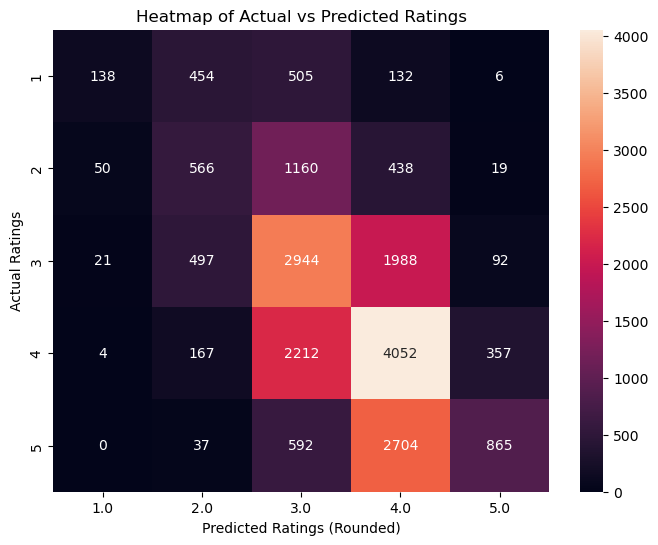

In [31]:
plt.figure(figsize=(8, 6))
sns.heatmap(pd.crosstab(test_ratings, np.round(pred_ratings)), annot=True, fmt="d", cmap="rocket")
plt.xlabel("Predicted Ratings (Rounded)")
plt.ylabel("Actual Ratings")
plt.title("Heatmap of Actual vs Predicted Ratings")
plt.show()

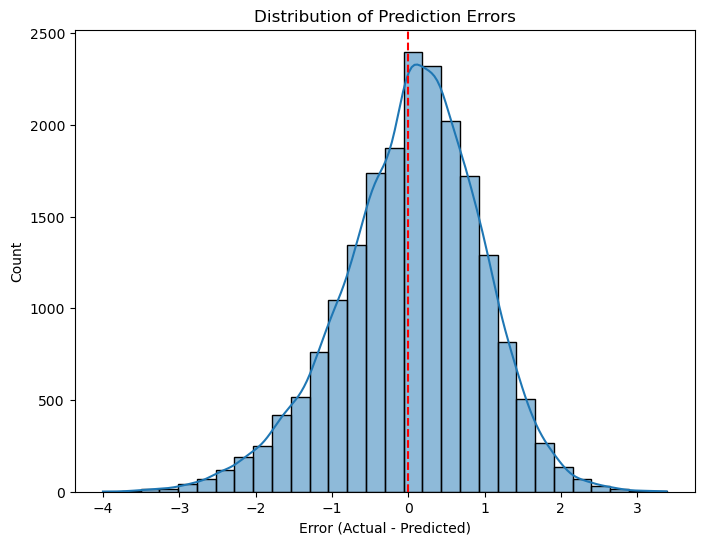

In [34]:
errors = test_ratings - pred_ratings
plt.figure(figsize=(8, 6))
sns.histplot(errors, bins=30, kde=True)
plt.xlabel("Error (Actual - Predicted)")
plt.axvline(0, color='red', linestyle='--')
plt.title("Distribution of Prediction Errors")
plt.show()